<a href="https://colab.research.google.com/github/icaro1518/pronostico_serie_temporal_produccion/blob/main/Analisis_serie_de_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de serie de tiempo para su pronóstico por el modelo de Holt-Winters y Prophet de Facebook

En este proyecto se hace uso de el modelo de pronósticos de series de tiempo creado por Facebook llamado Prophet y el filtro para series de tiempo con el objetivo de pronósticos llamado Holt-Winters. El análisis se realizó sobre los datos diarios de producción de una empresa anónima. Se cuenta con aproximadamente 683 datos, algunos de estos con información faltante

## Pronósticos - Análisis exploratorio de los datos

* Limpiar base de datos (agrupar por meses y retirar datos faltantes)

In [1]:
import pandas as pd
from pandas import datetime
import numpy as np
import matplotlib.pyplot as plt
#Para indicadores de desempeño

def MAD_forecast(datosReales,datosPronostico):
    
    suma=0
    for i in range(len(datosReales)): 
        suma+=abs((datosReales[i]-datosPronostico[i]))
    
    return suma/len(datosReales)

def MAPE_forecast(datosReales,datosPronostico):
    
    suma=0
    for i in range(len(datosReales)): 
        suma+=abs((datosReales[i]-datosPronostico[i])/datosReales[i])
    
    return suma/len(datosReales)

def sumErrors_forecast(datosReales,datosPronostico):
    
    suma=0
    for i in range(len(datosReales)): 
        suma+=datosReales[i]-datosPronostico[i]
    return suma

def averageError_forecast(datosReales,datosPronostico):
    return sumErrors_forecast(datosReales,datosPronostico)/len(datosReales)

In [2]:
from sklearn.metrics import mean_squared_error

#Para realizar prueba estadística de Dickey-Fuller
from statsmodels.tsa.stattools import adfuller 

#Para gráficos de autocorrelación (simple y parcial)
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

#Para creación del modelo ARIMA
from statsmodels.tsa.arima_model import ARIMA

#Para creación de modelo Holt-Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Para descomposición de series de tiempo
import statsmodels.api as sm

#Para utilizar modelo de Prophet Facebook
from fbprophet import Prophet

#Para utilizar la validación cruzada en Prophet
from fbprophet.diagnostics import cross_validation

#Para utilizar las medidas de desempeño generadas por Prophet
from fbprophet.diagnostics import performance_metrics

import matplotlib as mpl
 
from google.colab import files

#Se puede subir el archivo directamente como excel
uploaded = files.upload()
df = pd.DataFrame(pd.read_excel("datos2.xlsx"))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving datos2.xlsx to datos2.xlsx


In [3]:
#Cantidad de datos faltantes
missing_values_count = df.isnull().sum()
total_missing = missing_values_count.sum()
total_missing

52

In [4]:
#Como hay valores faltantes, estos son retirados del dataframe
df.dropna(inplace=True)
missing_values_count = df.isnull().sum()
total_missing = missing_values_count.sum()
total_missing

0

In [28]:
#Convertir los datos al formato de fecha real utilizado por los paquetes para análisis de series de tiempo

df["fecha"]=pd.to_datetime(pd.Series(df["fecha"]), format="%d/%m/%Y") 

#Realizar el agrupamiento de los datos por mes. NOTA: Se debe de colocar como indice la fecha antes de realizar el resample (agrupamiento)
df.index = df["fecha"]
dfMes=df.resample("M").sum()
dfMes.head()

,valor
fecha,
2015-03-31,226580.0
2015-04-30,268320.0
2015-05-31,255420.0
2015-06-30,336690.0
2015-07-31,336045.0


### Gráfico de los datos agrupados por meses
Este gráfico que parece tener cierta tendencia (decreciente) y estacionalidad cada año, sin embargo, esto no es lo suficientemente claro


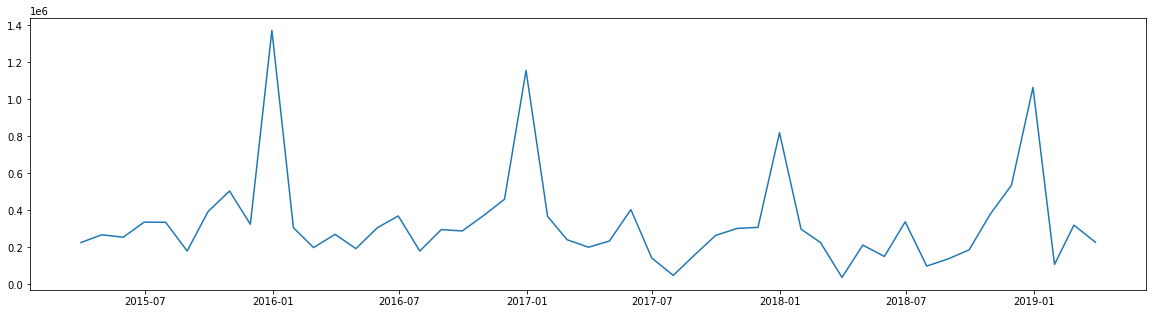

In [6]:
plt.figure(figsize=(20,5))
plt.plot(dfMes.index,dfMes.valor)

###Test de Dickey-Fuller
El test busca demostrar la estacionariedad de los datos a través de la prueba de hipótesis:

$H_0:$ La serie de tiempo es no estacionaria
$H_1:$ La serie de tiempo es estacionaria 

Dado que el estadístico de prueba es menor que el valor crítico arrojado para el nivel de signifancia escogido $\alpha=0.05$, se rechaza la hipótesis nula, por lo que se afirma que la serie de tiempo cuenta con estacionariedad

In [7]:
#Test de Dickey-Fuller para datos mensuales

X = dfMes["valor"].values
result = adfuller(X)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Value:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key,value))

ADF Statistic: -0.994725
p-value: 0.755183
Critical Value:
	1%: -3.621
	5%: -2.944
	10%: -2.610


###Gráficos de autocorrelación

Por medio de los gráficos de autocorrelación simple y parcial, es posible notar que la serie de tiempo depende de sus valores pasados en aproximadamente un año. Se puede observar también, que probablemente existe una estacionalidad anual para esta serie. Esto lo podemos afirmar debido a que se encuentra que en el periodo 12 la autocorrelación es significativa

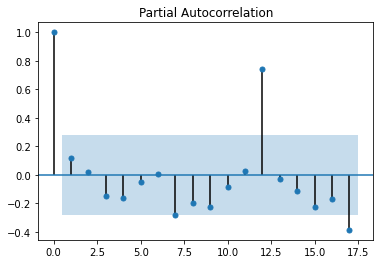

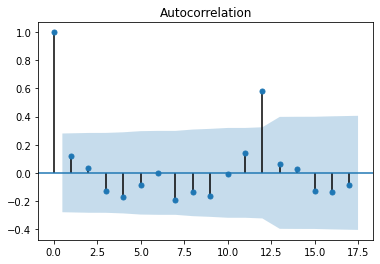

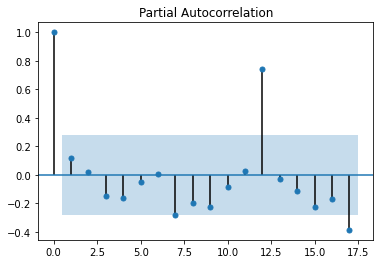

In [26]:
#Autocorrelación mensual

plot_acf(dfMes["valor"]) 
plot_pacf(dfMes["valor"])

###Boxplot

In [38]:
#Añadir columna de mes para boxplots

dfMes["mes"]=dfMes.reset_index()["fecha"].astype(str).apply(lambda x:int(x.split("-")[1])).tolist()
dfMes.head()


,valor,mes
fecha,,
2015-03-31,226580.0,3
2015-04-30,268320.0,4
2015-05-31,255420.0,5
2015-06-30,336690.0,6
2015-07-31,336045.0,7


####Boxplot mensual de los datos
Se evidencia un alto valor de la media en el mes de diciembre todos los años

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



<Figure size 1440x360 with 0 Axes>

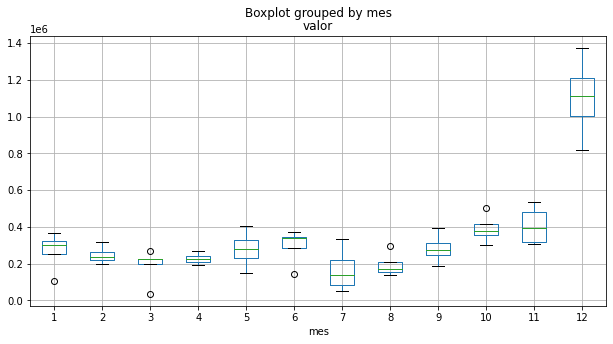

In [40]:
%matplotlib inline
plt.figure(figsize=(20,5))
dfMes.boxplot(column="valor",by="mes",figsize=(10,5))


Al igual que en el anterior gráfico de autocorrelación, podemos observar que en el periodo 12 es significativa la autocorrelación y adicionalmente observamos que parece que hay una estacionalidad cada 12 meses

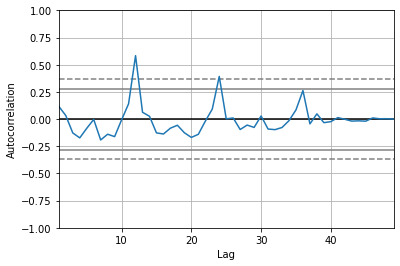

In [11]:
pd.plotting.autocorrelation_plot(dfMes.valor)

###Descomposición de la serie

In [12]:
#Descomposición de la serie de tiempo. Creación del modelo

model = sm.tsa.seasonal_decompose(dfMes.valor,freq = 12)

#### Gráfico de descomposición de la serie

A través de la descomposición de la serie, encontramos que si existe una tendencia decreciente en la serie, además de contar con cierta estacionalidad anual

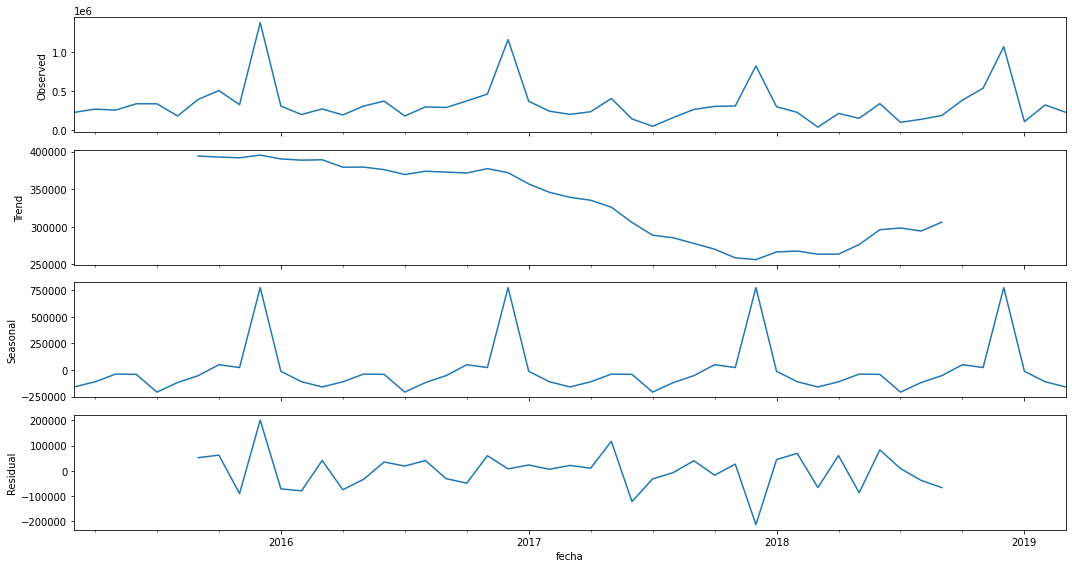

In [13]:
model.trend,model.seasonal,model.resid

with mpl.rc_context():
    mpl.rc("figure",figsize=(15,8))
    model.plot()
    plt.show()

##Separación datos de entrenamiento y datos de prueba

Se toman como datos de entrenamiento desde marzo de 2015 hasta diciembre de 2018. Resultando así 46 valores de entrenamiento y 3 valores de prueba. Esto debido a las indicaciones del instructor

In [41]:
dfMesTrain = dfMes[:46]
dfMesTest = dfMes[46:]

##Análisis de la serie de tiempo a través de Holt-Winters

Se obtienen varios indicadores para las diferentes combinaciones de tendencia y estacionalidad, para lo cual se selecciona una serie con tendencia multiplicativa, estacionalidad aditiva y el parámetro damped=True

In [42]:
# Con tendencia multiplicativa y estacionalidad aditiva. y damped=True, se tiene el siguiente resultado de indicadores
# El MSE es: 22051749254.90952
# El MAD es: 138254.89401510128
# El MAPE es: 0.6862169934853489

# Sin damped
# El MSE es: 45610074699.86066
# El MAD es: 184289.8041427209
# El MAPE es: 0.7603999576493207
########################################################################
#No es con tendencia y estacionalidad multiplicativa- no funciona con esta

########################################################################
# Con tendencia y estacionalidad aditiva y damped=True
# El MSE es: 23344934372.610943
# El MAD es: 134447.1487699038
# El MAPE es: 0.9411909913032659

#Sin damped
# El MSE es: 22601744620.742966
# El MAD es: 149075.62449496242
# El MAPE es: 0.8830944149723002
#########################################################################
# Con tendencia aditiva y estacionalidad multiplicativa y damped=True
# El MSE es: 32662783106.641876
# El MAD es: 156519.4980980813
# El MAPE es: 1.0975101142901607
#Con damped=False no hay un cambio grande en el valor de los indicadores de desempeño

modelHoltWinters = ExponentialSmoothing(dfMesTrain.valor, trend = "add" , seasonal = "mul" , seasonal_periods = 12)

In [43]:
#Se genera el ajuste del modelo

fit = modelHoltWinters.fit(optimized = True)
fit.params

{'damping_slope': nan,
 'initial_level': 184161.49999880348,
 'initial_seasons': array([1.53558308, 1.60615479, 1.56665138, 1.84931873, 1.73476961,
        1.02322934, 1.89504113, 2.55532474, 1.54543304, 7.31250645,
        2.13075312, 1.76390695]),
 'initial_slope': 0.0,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.15789473685389377,
 'smoothing_seasonal': 0.842105263160105,
 'smoothing_slope': 0.0526315789606305,
 'use_boxcox': False}

In [44]:
#Predicción del modelo con datos de acuerdo a la regla establecida de entrenamiento y prueba
forecast_HW =fit.predict(start=46, end=48)
forecast_HW

2019-01-31    374203.569760
2019-02-28    276065.820898
2019-03-31     68959.254624
Freq: M, dtype: float64

Gráfico de la predicción obtenida por medio del filtro de Hol-Winters y la serie original

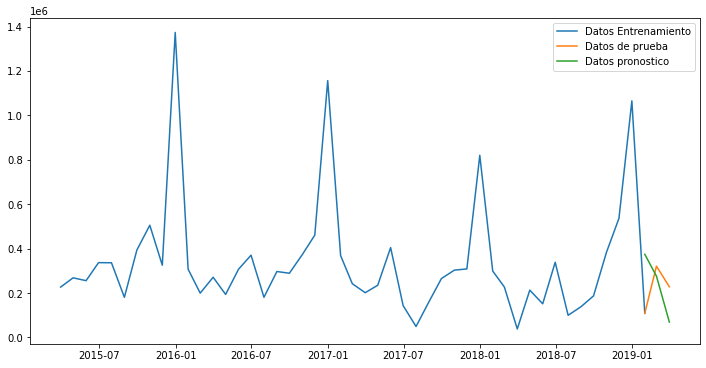

In [45]:
dfMesTrainPlot=dfMes[:47]

plt.figure(figsize=(12,6))

plt.plot(dfMesTrainPlot.index,dfMesTrainPlot.valor, label="Datos Entrenamiento")
plt.plot(dfMesTest.index,dfMesTest.valor, label="Datos de prueba")
plt.plot(forecast_HW.index,forecast_HW,label="Datos pronostico")

plt.legend(loc='best')

Se generan una serie de medidas de validación para determinar el error y la precisión del modelo

In [46]:
print("El MSE es: "+str(mean_squared_error(dfMesTest.valor,forecast_HW.values)))
print("El MAD es: "+str(MAD_forecast(dfMesTest.valor,forecast_HW.values)))
print("El MAPE es: " +str(MAPE_forecast(dfMesTest.valor,forecast_HW.values)))
print("El error promedio es: " +str(averageError_forecast(dfMesTest.valor,forecast_HW.values)))
print("La suma de errores es: " +str(sumErrors_forecast(dfMesTest.valor,forecast_HW.values)))

El MSE es: 32662783117.091843
El MAD es: 156519.4980793041
El MAPE es: 1.0975101144064838
El error promedio es: -20762.21509405282
La suma de errores es: -62286.64528215845


##Análisis de la serie de tiempo utilizando el método de *Prophet* de Facebook

In [49]:
dfProphet = dfMes

dfProphet.reset_index(inplace=True) #utilizar una sola vez
dfProphet.rename(columns={"valor":"y","fecha":"ds"},inplace=True)

dfProphet.tail()

,ds,y,mes
44,2018-11-30,536123.0,11
45,2018-12-31,1065157.0,12
46,2019-01-31,108281.0,1
47,2019-02-28,320701.0,2
48,2019-03-31,227960.0,3


In [50]:
#Ajuste del modelo Prophet
m = Prophet(yearly_seasonality=True)
m.fit(dfProphet)
m.params

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'beta': array([[-0.06463975,  0.12230009, -0.06929665,  0.18083733,  0.12606739,
         -0.14670679, -0.27227661,  0.28118353, -0.43868024, -0.33821471,
         -0.51127137, -0.03129281, -0.57314611,  0.29693088, -0.16984001,
         -0.20976192,  0.06083503,  0.27922519,  0.06913478, -0.03853354]]),
 'delta': array([[-1.20833083e-09, -5.68938864e-10,  1.50897673e-10,
         -1.38248121e-09, -1.59133026e-09, -1.45440914e-09,
          1.36264471e-09,  3.09595394e-10,  3.56979517e-10,
         -8.35413907e-10, -6.85005248e-11,  1.33060819e-09,
         -2.11763824e-10, -8.13875264e-10,  1.19407888e-09,
          3.65596961e-06,  5.64953474e-05,  5.80119240e-06,
          6.05044252e-05,  2.73958927e-04,  6.48609856e-04,
          6.30332983e-04,  6.19034657e-05,  2.57001409e-05,
          1.32849607e-04]]),
 'k': array([[-0.11065158]]),
 'm': array([[0.27386111]]),
 'sigma_obs': array([[0.05426935]]),
 'trend': array([[0.27386111, 0.271589  , 0.26924116, 0.26696905, 0.26462121,
 

In [51]:
#Generar las fechas futuras a 3 meses para que el pronóstico generado sea mensual

future = m.make_future_dataframe(periods=3, freq="M")
future.tail()

,ds
47,2019-02-28
48,2019-03-31
49,2019-04-30
50,2019-05-31
51,2019-06-30


Generación del pronóstico para los siguientes 3 meses junto a su intervalo de confianza


In [52]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3) #Generar el prónostico para los siguientes 3 meses

,ds,yhat,yhat_lower,yhat_upper
49,2019-04-30,152575.618053,53469.855901,247628.478321
50,2019-05-31,120309.215856,26058.677562,220936.528363
51,2019-06-30,215761.274240,124376.461699,307670.510694


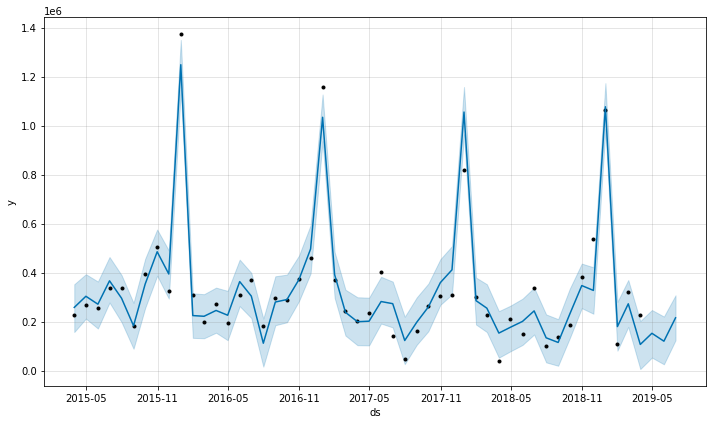

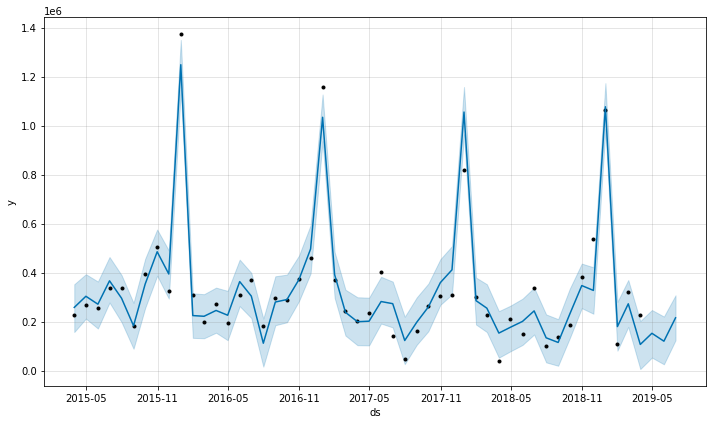

In [53]:
m.plot(forecast)

Se utiliza el método de validación cruzada para evaluar datos de entrenamiento contra datos de prueba definidos por un corte

In [54]:
dfProphet_cv = cross_validation(m, initial='1350 days', horizon = '90 days')
dfProphet_cv.tail()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-31,209438.621977,114359.153216,298455.045916,108281.0,2018-12-31
1,2019-02-28,228772.382237,130994.736423,325014.901910,320701.0,2018-12-31
2,2019-03-31,32474.258169,-54226.596289,123354.766200,227960.0,2018-12-31


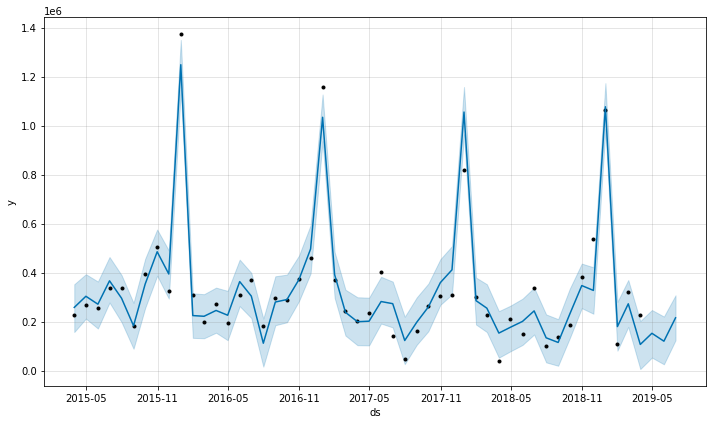

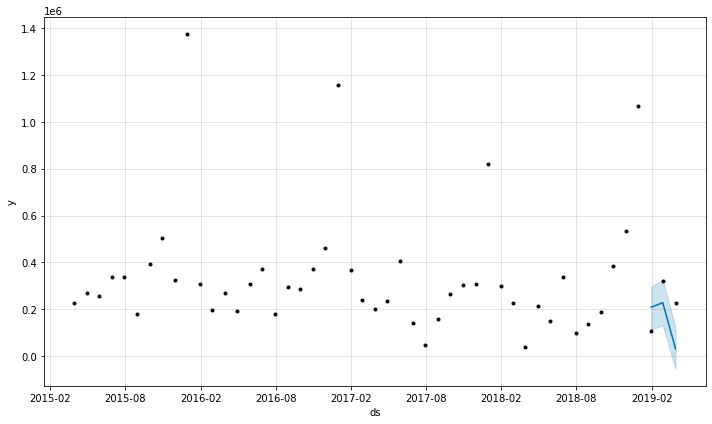

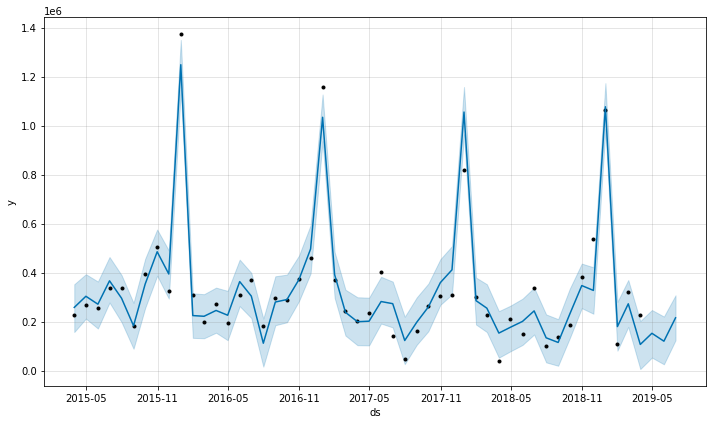

In [55]:
dfProphet_cv
m.plot(dfProphet_cv)
plt.ion()
m.plot(forecast)

Medidas de desempeño del modelo siendo comparado el pronóstico utilizando los datos de entrenamiento contra los datos de prueba


In [56]:
df_performance = performance_metrics(dfProphet_cv)
df_performance.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,31 days,1.023286e+10,101157.621977,101157.621977,0.934214,0.934214,0.0
1,59 days,8.450871e+09,91928.617763,91928.617763,0.286649,0.286649,1.0
2,90 days,3.821468e+10,195485.741831,195485.741831,0.857544,0.857544,0.0


Se generan una serie de medidas de validación para determinar el error y la precisión del modelo

In [57]:
#Medidas de validación

print("El MSE es: "+str(mean_squared_error(dfMesTest.valor,dfProphet_cv.yhat)))
print("El MAD es: "+str(MAD_forecast(dfMesTest.valor,dfProphet_cv.yhat)))
print("El MAPE es: " +str(MAPE_forecast(dfMesTest.valor,dfProphet_cv.yhat)))
print("El error promedio es: " +str(averageError_forecast(dfMesTest.valor,dfProphet_cv.yhat)))
print("La suma de errores es: " +str(sumErrors_forecast(dfMesTest.valor,dfProphet_cv.yhat)))

El MSE es: 18966136835.717476
El MAD es: 129523.99385709995
El MAPE es: 0.6928023341749979
El error promedio es: 62085.57920547619
La suma de errores es: 186256.73761642858
